*Note: This is not yet ready, but shows the direction I'm leaning in for Fourth Edition Search.*

# State-Space Search

This notebook describes several state-space search algorithms, and how they can be used to solve a variety of problems. We start with a simple algorithm and a simple domain: finding a route from city to city.  Later we will explore other algorithms and domains.

## The Route-Finding Domain

Like all state-space search problems, in a route-finding problem you will be given:
- A start state (for example, `'A'` for the city Arad).
- A goal state (for example, `'B'` for the city Bucharest).
- Actions that can change state (for example, driving from `'A'` to `'S'`).

You will be asked to find:
- A path from the start state, through intermediate states, to the goal state.

We'll use this map:

<img src="http://robotics.cs.tamu.edu/dshell/cs625/images/map.jpg" height="366" width="603">

A state-space search problem can be represented by a *graph*, where the vertexes of the graph are the states of the problem (in this case, cities) and the edges of the graph are the actions (in this case, driving along a road).

We'll represent a city by its single initial letter. 
We'll represent the graph of connections as a `dict` that maps each city to a list of the neighboring cities (connected by a road). For now we don't explicitly represent the actions, nor the distances
between cities.

In [3]:
romania = {
 'A': ['Z', 'T', 'S'],
 'B': ['F', 'P', 'G', 'U'],
 'C': ['D', 'R', 'P'],
 'D': ['M', 'C'],
 'E': ['H'],
 'F': ['S', 'B'],
 'G': ['B'],
 'H': ['U', 'E'],
 'I': ['N', 'V'],
 'L': ['T', 'M'],
 'M': ['L', 'D'],
 'N': ['I'],
 'O': ['Z', 'S'],
 'P': ['R', 'C', 'B'],
 'R': ['S', 'C', 'P'],
 'S': ['A', 'O', 'F', 'R'],
 'T': ['A', 'L'],
 'U': ['B', 'V', 'H'],
 'V': ['U', 'I'],
 'Z': ['O', 'A']}

Suppose we want to get from `A` to `B`. Where can we go from the start state, `A`?

In [2]:
romania['A']

['Z', 'T', 'S']

We see that from `A` we can get to any of the three cities `['Z', 'T', 'S']`. Which should we choose?  *We don't know.* That's the whole point of *search*: we don't know which immediate action is best, so we'll have to explore, until we find a *path* that leads to the goal. 

How do we explore? We'll start with a simple algorithm that will get us from `A` to `B`. We'll keep a *frontier*&mdash;a collection of not-yet-explored states&mdash;and expand the frontier outward until it reaches the goal. To be more precise:

- Initially, the only state in the frontier is the start state, `'A'`.
- Until we reach the goal, or run out of states in the frontier to explore, do the following:
  - Remove the first state from the frontier. Call it `s`.
  - If `s` is the goal, we're done. Return the path to `s`.
  - Otherwise, consider all the neighboring states of `s`. For each one:
    - If we have not previously explored the state, add it to the end of the frontier.
    - Also keep track of the previous state that led to this new neighboring state; we'll need this to reconstruct the path to the goal, and to keep us from re-visiting previously explored states.
    
# A Simple Search Algorithm: `breadth_first`
    
The function `breadth_first` implements this strategy:

In [4]:
from collections import deque # Doubly-ended queue: pop from left, append to right.

def breadth_first(start, goal, neighbors):
    "Find a shortest sequence of states from start to the goal."
    frontier = deque([start]) # A queue of states
    previous = {start: None}  # start has no previous state; other states will
    while frontier:
        s = frontier.popleft()
        if s == goal:
            return path(previous, s)
        for s2 in neighbors[s]:
            if s2 not in previous:
                frontier.append(s2)
                previous[s2] = s
                
def path(previous, s): 
    "Return a list of states that lead to state s, according to the previous dict."
    return [] if (s is None) else path(previous, previous[s]) + [s]

A couple of things to note: 

1. We always add new states to the end of the frontier queue. That means that all the states that are adjacent to the start state will come first in the queue, then all the states that are two steps away, then three steps, etc.
That's what we mean by *breadth-first* search.
2. We recover the path to an `end` state by following the trail of `previous[end]` pointers, all the way back to `start`.
The dict `previous` is a map of `{state: previous_state}`. 
3. When we finally get an `s` that is the goal state, we know we have found a shortest path, because any other state in the queue must correspond to a path that is as long or longer.
3. Note that `previous`  contains all the states that are currently in `frontier` as well as all the states that were in `frontier` in the past.
4. If no path to the goal is found, then `breadth_first` returns `None`. If a path is found, it returns the sequence of states on the path.

Some examples:

In [5]:
breadth_first('A', 'B', romania)

['A', 'S', 'F', 'B']

In [6]:
breadth_first('L', 'N', romania)

['L', 'T', 'A', 'S', 'F', 'B', 'U', 'V', 'I', 'N']

In [7]:
breadth_first('N', 'L', romania)

['N', 'I', 'V', 'U', 'B', 'F', 'S', 'A', 'T', 'L']

In [8]:
breadth_first('E', 'E', romania)

['E']

Now let's try a different  kind of problem that can be solved with the same search function.

## Word Ladders Problem

A *word ladder* problem is this: given a start word and a goal word, find the shortest way to transform the start word into the goal word by changing one letter at a time, such that each change results in a word. For example starting with `green` we can reach `grass` in 7 steps:

`green` &rarr; `greed` &rarr; `treed` &rarr; `trees` &rarr; `tress` &rarr; `cress` &rarr; `crass` &rarr; `grass`

We will need a dictionary of words. I'll make a local copy of the list of 5-letter words from the [Stanford GraphBase](http://www-cs-faculty.stanford.edu/~uno/sgb.html) project (the `!` indicates that these are shell commands, not Python):

In [9]:
! [ -e sgb-words.txt ] || curl -O http://www-cs-faculty.stanford.edu/~uno/sgb-words.txt

In [10]:
! head sgb-words.txt

which
there
their
about
would
these
other
words
could
write


We can assign `WORDS` to be the set of all the words in this file:

In [11]:
WORDS = set(open('sgb-words.txt').read().split())
len(WORDS)

5757

And define `neighboring_words` to return the set of all words that are a one-letter change away from a given `word`:

In [13]:
def neighboring_words(word):
    "All words that are one letter away from this word."
    neighbors = {word[:i] + c + word[i+1:]
                 for i in range(len(word))
                 for c in 'abcdefghijklmnopqrstuvwxyz'
                 if c != word[i]}
    return neighbors & WORDS

For example:

In [14]:
neighboring_words('hello')

{'cello', 'hallo', 'hells', 'hullo', 'jello'}

In [15]:
neighboring_words('world')

{'would'}

Now we can create  `word_neighbors` as a dict of `{word: {neighboring_word, ...}}`: 

In [16]:
word_neighbors = {word: neighboring_words(word)
                  for word in WORDS}

Now the `breadth_first` function can be used to solve a word ladder problem:

In [17]:
breadth_first('green', 'grass', word_neighbors)

['green', 'greed', 'treed', 'trees', 'treys', 'greys', 'grays', 'grass']

In [18]:
breadth_first('smart', 'brain', word_neighbors)

['smart',
 'start',
 'stars',
 'sears',
 'bears',
 'beans',
 'brans',
 'brand',
 'braid',
 'brain']

In [17]:
breadth_first('frown', 'smile', word_neighbors)

['frown',
 'flown',
 'flows',
 'slows',
 'stows',
 'stoas',
 'stoae',
 'stole',
 'stile',
 'smile']

# More General Search Algorithms

Now we'll embelish the `breadth_first` algorithm to make a family of search algorithms with more capabilities:

1. We distinguish between an *action* and the *result* of an action.
3. We allow different measures of the cost of a solution (not just the number of steps in the sequence).
4. We search through the state space in an order that is more likely to lead to an optimal solution quickly.

Here's how we do these things:

1. Instead of having a graph of neighboring states, we instead have an object of type *Problem*. A Problem
has one method, `Problem.actions(state)` to return a collection of the actions that are allowed in a state,
and another method, `Problem.result(state, action)` that says what happens when you take an action.
2. We keep a set, `explored` of states that have already been explored. We also have a class, `Frontier`, that makes it efficient to ask if a state is on the frontier.
3. Each action has a cost associated with it (in fact, the cost can vary with both the state and the action).
4. The `Frontier` class acts as a priority queue, allowing the "best" state to be explored next.
We represent a sequence of actions and resulting states as a linked list of `Node` objects.

The algorithm `breadth_first_search` is basically the same  as `breadth_first`, but using our new conventions:

In [18]:
def breadth_first_search(problem):
    "Search for goal; paths with least number of steps first."
    if problem.is_goal(problem.initial): 
        return Node(problem.initial)
    frontier = FrontierQ(Node(problem.initial), LIFO=False)
    explored = set()
    while frontier:
        node = frontier.pop()
        explored.add(node.state)
        for action in problem.actions(node.state):
            child = node.child(problem, action)
            if child.state not in explored and child.state not in frontier:
                if problem.is_goal(child.state):
                    return child
                frontier.add(child)

Next is `uniform_cost_search`, in which each step can have a different cost, and we still consider first one os the states with minimum cost so far.

In [19]:
def uniform_cost_search(problem, costfn=lambda node: node.path_cost):
    frontier = FrontierPQ(Node(problem.initial), costfn)
    explored = set()
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        explored.add(node.state)
        for action in problem.actions(node.state):
            child = node.child(problem, action)
            if child.state not in explored and child not in frontier:
                frontier.add(child)
            elif child in frontier and frontier.cost[child] < child.path_cost:
                frontier.replace(child)

Finally, `astar_search`  in which the cost includes an estimate of the distance to the goal as well as the distance travelled so far.

In [20]:
def astar_search(problem, heuristic):
    costfn = lambda node: node.path_cost + heuristic(node.state)
    return uniform_cost_search(problem, costfn)

# Search Tree Nodes

The solution to a search problem is now a linked list of `Node`s, where each `Node`
includes a `state` and the `path_cost` of getting to the state. In addition, for every `Node` except for the first (root) `Node`, there is a previous `Node` (indicating the state that lead to this `Node`) and an `action` (indicating the action taken to get here).

In [21]:
class Node(object):
    """A node in a search tree. A search tree is spanning tree over states.
    A Node contains a state, the previous node in the tree, the action that
    takes us from the previous state to this state, and the path cost to get to 
    this state. If a state is arrived at by two paths, then there are two nodes 
    with the same state."""

    def __init__(self, state, previous=None, action=None, step_cost=1):
        "Create a search tree Node, derived from a previous Node by an action."
        self.state     = state
        self.previous  = previous
        self.action    = action
        self.path_cost = 0 if previous is None else (previous.path_cost + step_cost)

    def __repr__(self): return "<Node {}: {}>".format(self.state, self.path_cost)
    
    def __lt__(self, other): return self.path_cost < other.path_cost
    
    def child(self, problem, action):
        "The Node you get by taking an action from this Node."
        result = problem.result(self.state, action)
        return Node(result, self, action, 
                    problem.step_cost(self.state, action, result))    

# Frontiers

A frontier is a collection of Nodes that acts like both a Queue and a Set. A frontier, `f`, supports these operations:

* `f.add(node)`: Add a node to the Frontier.

* `f.pop()`: Remove and return the "best" node from the frontier.

* `f.replace(node)`: add this node and remove a previous node with the same state.

* `state in f`: Test if some node in the frontier has arrived at state.

* `f[state]`: returns the node corresponding to this state in frontier.

* `len(f)`: The number of Nodes in the frontier. When the frontier is empty, `f` is *false*.

We provide two kinds of frontiers: One for "regular" queues, either first-in-first-out (for breadth-first search) or last-in-first-out (for depth-first search), and one for priority queues, where you can specify what cost function on nodes you are trying to minimize.

In [22]:
from collections import OrderedDict
import heapq

class FrontierQ(OrderedDict):
    "A Frontier that supports FIFO or LIFO Queue ordering."
    
    def __init__(self, initial, LIFO=False):
        """Initialize Frontier with an initial Node.
        If LIFO is True, pop from the end first; otherwise from front first."""
        self.LIFO = LIFO
        self.add(initial)
    
    def add(self, node):
        "Add a node to the frontier."
        self[node.state] = node
        
    def pop(self):
        "Remove and return the next Node in the frontier."
        (state, node) = self.popitem(self.LIFO)
        return node
    
    def replace(self, node):
        "Make this node replace the nold node with the same state."
        del self[node.state]
        self.add(node)

In [23]:
class FrontierPQ:
    "A Frontier ordered by a cost function; a Priority Queue."
    
    def __init__(self, initial, costfn=lambda node: node.path_cost):
        "Initialize Frontier with an initial Node, and specify a cost function."
        self.heap   = []
        self.states = {}
        self.costfn = costfn
        self.add(initial)
    
    def add(self, node):
        "Add node to the frontier."
        cost = self.costfn(node)
        heapq.heappush(self.heap, (cost, node))
        self.states[node.state] = node
        
    def pop(self):
        "Remove and return the Node with minimum cost."
        (cost, node) = heapq.heappop(self.heap)
        self.states.pop(node.state, None) # remove state
        return node
    
    def replace(self, node):
        "Make this node replace a previous node with the same state."
        if node.state not in self:
            raise ValueError('{} not there to replace'.format(node.state))
        for (i, (cost, old_node)) in enumerate(self.heap):
            if old_node.state == node.state:
                self.heap[i] = (self.costfn(node), node)
                heapq._siftdown(self.heap, 0, i)
                return

    def __contains__(self, state): return state in self.states
    
    def __len__(self): return len(self.heap)

# Search Problems

`Problem` is the abstract class for all search problems. You can define your own class of problems as a subclass of `Problem`. You will need to override the `actions` and  `result` method to describe how your problem works. You will also have to either override `is_goal` or pass a collection of goal states to the initialization method.  If actions have different costs, you should override the `step_cost` method. 

In [24]:
class Problem(object):
    """The abstract class for a search problem."""

    def __init__(self, initial=None, goals=(), **additional_keywords):
        """Provide an initial state and optional goal states.
        A subclass can have additional keyword arguments."""
        self.initial = initial  # The initial state of the problem.
        self.goals = goals      # A collection of possibe goal states.
        self.__dict__.update(**additional_keywords)

    def actions(self, state):
        "Return a list of actions executable in this state."
        raise NotImplementedError # Override this!

    def result(self, state, action):
        "The state that results from executing this action in this state."
        raise NotImplementedError # Override this!

    def is_goal(self, state):
        "True if the state is a goal." 
        return state in self.goals # Optionally override this!

    def step_cost(self, state, action, result=None):
        "The cost of taking this action from this state."
        return 1 # Override this if actions have different costs        

In [25]:
def action_sequence(node):
    "The sequence of actions to get to this node."
    actions = []
    while node.previous:
        actions.append(node.action)
        node = node.previous
    return actions[::-1]

def state_sequence(node):
    "The sequence of states to get to this node."
    states = [node.state]
    while node.previous:
        node = node.previous
        states.append(node.state)
    return states[::-1]

# Two Location Vacuum World

In [26]:
dirt  = '*'
clean = ' '

class TwoLocationVacuumProblem(Problem):
    """A Vacuum in a world with two locations, and dirt.
    Each state is a tuple of (location, dirt_in_W, dirt_in_E)."""

    def actions(self, state): return ('W', 'E', 'Suck')
    
    def is_goal(self, state): return dirt not in state
 
    def result(self, state, action):
        "The state that results from executing this action in this state."        
        (loc, dirtW, dirtE) = state
        if   action == 'W':                   return ('W', dirtW, dirtE)
        elif action == 'E':                   return ('E', dirtW, dirtE)
        elif action == 'Suck' and loc == 'W': return (loc, clean, dirtE)
        elif action == 'Suck' and loc == 'E': return (loc, dirtW, clean) 
        else: raise ValueError('unknown action: ' + action)

In [27]:
problem = TwoLocationVacuumProblem(initial=('W', dirt, dirt))
result = uniform_cost_search(problem)
result

<Node ('E', ' ', ' '): 3>

In [28]:
action_sequence(result)

['Suck', 'E', 'Suck']

In [29]:
state_sequence(result)

[('W', '*', '*'), ('W', ' ', '*'), ('E', ' ', '*'), ('E', ' ', ' ')]

In [30]:
problem = TwoLocationVacuumProblem(initial=('E', clean, dirt))
result = uniform_cost_search(problem)
action_sequence(result)

['Suck']

# Water Pouring Problem

Here is another problem domain, to show you how to define one. The idea is that we have a number of water jugs and a water tap and the goal is to measure out a specific amount of water (in, say, ounces or liters). You can completely fill or empty a jug, but because the jugs don't have markings on them, you can't partially fill them with a specific amount. You can, however, pour one jug into another, stopping when the seconfd is full or the first is empty.

In [31]:
class PourProblem(Problem):
    """Problem about pouring water between jugs to achieve some water level.
    Each state is a tuples of levels. In the initialization, provide a tuple of 
    capacities, e.g. PourProblem(capacities=(8, 16, 32), initial=(2, 4, 3), goals={7}), 
    which means three jugs of capacity 8, 16, 32, currently filled with 2, 4, 3 units of 
    water, respectively, and the goal is to get a level of 7 in any one of the jugs."""
    
    def actions(self, state):
        """The actions executable in this state."""
        jugs = range(len(state))
        return ([('Fill', i)    for i in jugs if state[i] != self.capacities[i]] +
                [('Dump', i)    for i in jugs if state[i] != 0] +
                [('Pour', i, j) for i in jugs for j in jugs if i != j])

    def result(self, state, action):
        """The state that results from executing this action in this state."""
        result = list(state)
        act, i, j = action[0], action[1], action[-1]
        if act == 'Fill': # Fill i to capacity
            result[i] = self.capacities[i]
        elif act == 'Dump': # Empty i
            result[i] = 0
        elif act == 'Pour':
            a, b = state[i], state[j]
            result[i], result[j] = ((0, a + b) 
                                    if (a + b <= self.capacities[j]) else
                                    (a + b - self.capacities[j], self.capacities[j]))
        else:
            raise ValueError('unknown action', action)
        return tuple(result)

    def is_goal(self, state):
        """True if any of the jugs has a level equal to one of the goal levels."""
        return any(level in self.goals for level in state)

In [32]:
p7 = PourProblem(initial=(2, 0), capacities=(5, 13), goals={7})
p7.result((2, 0),  ('Fill', 1))

(2, 13)

In [33]:
result = uniform_cost_search(p7)
action_sequence(result)

[('Pour', 0, 1), ('Fill', 0), ('Pour', 0, 1)]

# Visualization Output

In [34]:
def showpath(searcher, problem):
    "Show what happens when searcvher solves problem."
    problem = Instrumented(problem)
    print('\n{}:'.format(searcher.__name__))
    result = searcher(problem)
    if result:
        actions = action_sequence(result)
        state = problem.initial
        path_cost = 0
        for steps, action in enumerate(actions, 1):
            path_cost += problem.step_cost(state, action, 0)
            result = problem.result(state, action)
            print('  {} =={}==> {}; cost {} after {} steps'
                  .format(state, action, result, path_cost, steps,
                          '; GOAL!' if problem.is_goal(result) else ''))
            state = result
    msg = 'GOAL FOUND' if result else 'no solution'
    print('{} after {} results and {} goal checks'
          .format(msg, problem._counter['result'], problem._counter['is_goal']))
        
from collections import Counter

class Instrumented:
    "Instrument an object to count all the attribute accesses in _counter."
    def __init__(self, obj):
        self._object = obj
        self._counter = Counter()
    def __getattr__(self, attr):
        self._counter[attr] += 1
        return getattr(self._object, attr)    

In [35]:
showpath(uniform_cost_search, p7)


uniform_cost_search:
  (2, 0) ==('Pour', 0, 1)==> (0, 2); cost 1 after 1 steps
  (0, 2) ==('Fill', 0)==> (5, 2); cost 2 after 2 steps
  (5, 2) ==('Pour', 0, 1)==> (0, 7); cost 3 after 3 steps
GOAL FOUND after 83 results and 22 goal checks


In [36]:
p = PourProblem(initial=(0, 0), capacities=(7, 13), goals={2})
showpath(uniform_cost_search, p)


uniform_cost_search:
  (0, 0) ==('Fill', 0)==> (7, 0); cost 1 after 1 steps
  (7, 0) ==('Pour', 0, 1)==> (0, 7); cost 2 after 2 steps
  (0, 7) ==('Fill', 0)==> (7, 7); cost 3 after 3 steps
  (7, 7) ==('Pour', 0, 1)==> (1, 13); cost 4 after 4 steps
  (1, 13) ==('Dump', 1)==> (1, 0); cost 5 after 5 steps
  (1, 0) ==('Pour', 0, 1)==> (0, 1); cost 6 after 6 steps
  (0, 1) ==('Fill', 0)==> (7, 1); cost 7 after 7 steps
  (7, 1) ==('Pour', 0, 1)==> (0, 8); cost 8 after 8 steps
  (0, 8) ==('Fill', 0)==> (7, 8); cost 9 after 9 steps
  (7, 8) ==('Pour', 0, 1)==> (2, 13); cost 10 after 10 steps
GOAL FOUND after 110 results and 32 goal checks


In [37]:
class GreenPourProblem(PourProblem):    
    def step_cost(self, state, action, result=None):
        "The cost is the amount of water used in a fill."
        if action[0] == 'Fill':
            i = action[1]
            return self.capacities[i] - state[i]
        return 0

In [38]:
p = GreenPourProblem(initial=(0, 0), capacities=(7, 13), goals={2})
showpath(uniform_cost_search, p)


uniform_cost_search:
  (0, 0) ==('Fill', 0)==> (7, 0); cost 7 after 1 steps
  (7, 0) ==('Pour', 0, 1)==> (0, 7); cost 7 after 2 steps
  (0, 7) ==('Fill', 0)==> (7, 7); cost 14 after 3 steps
  (7, 7) ==('Pour', 0, 1)==> (1, 13); cost 14 after 4 steps
  (1, 13) ==('Dump', 1)==> (1, 0); cost 14 after 5 steps
  (1, 0) ==('Pour', 0, 1)==> (0, 1); cost 14 after 6 steps
  (0, 1) ==('Fill', 0)==> (7, 1); cost 21 after 7 steps
  (7, 1) ==('Pour', 0, 1)==> (0, 8); cost 21 after 8 steps
  (0, 8) ==('Fill', 0)==> (7, 8); cost 28 after 9 steps
  (7, 8) ==('Pour', 0, 1)==> (2, 13); cost 28 after 10 steps
GOAL FOUND after 184 results and 48 goal checks


In [39]:
def compare_searchers(problem, searchers=None):
    "Apply each of the search algorithms to the problem, and show results"
    if searchers is None: 
        searchers = (breadth_first_search, uniform_cost_search)
    for searcher in searchers:
        showpath(searcher, problem)

In [40]:
compare_searchers(p)


breadth_first_search:
  (0, 0) ==('Fill', 0)==> (7, 0); cost 7 after 1 steps
  (7, 0) ==('Pour', 0, 1)==> (0, 7); cost 7 after 2 steps
  (0, 7) ==('Fill', 0)==> (7, 7); cost 14 after 3 steps
  (7, 7) ==('Pour', 0, 1)==> (1, 13); cost 14 after 4 steps
  (1, 13) ==('Dump', 1)==> (1, 0); cost 14 after 5 steps
  (1, 0) ==('Pour', 0, 1)==> (0, 1); cost 14 after 6 steps
  (0, 1) ==('Fill', 0)==> (7, 1); cost 21 after 7 steps
  (7, 1) ==('Pour', 0, 1)==> (0, 8); cost 21 after 8 steps
  (0, 8) ==('Fill', 0)==> (7, 8); cost 28 after 9 steps
  (7, 8) ==('Pour', 0, 1)==> (2, 13); cost 28 after 10 steps
GOAL FOUND after 100 results and 31 goal checks

uniform_cost_search:
  (0, 0) ==('Fill', 0)==> (7, 0); cost 7 after 1 steps
  (7, 0) ==('Pour', 0, 1)==> (0, 7); cost 7 after 2 steps
  (0, 7) ==('Fill', 0)==> (7, 7); cost 14 after 3 steps
  (7, 7) ==('Pour', 0, 1)==> (1, 13); cost 14 after 4 steps
  (1, 13) ==('Dump', 1)==> (1, 0); cost 14 after 5 steps
  (1, 0) ==('Pour', 0, 1)==> (0, 1); cost 14

# Random Grid

An environment where you can move in any of 4 directions, unless there is an obstacle there.





In [41]:
import random

N, S, E, W = DIRECTIONS = [(0, 1), (0, -1), (1, 0), (-1, 0)]

def Grid(width, height, obstacles=0.1):
    """A 2-D grid, width x height, with obstacles that are either a collection of points,
    or a fraction between 0 and 1 indicating the density of obstacles, chosen at random."""
    grid = {(x, y) for x in range(width) for y in range(height)}
    if isinstance(obstacles, (float, int)):
        obstacles = random.sample(grid, int(width * height * obstacles))
    def neighbors(x, y):
        for (dx, dy) in DIRECTIONS:
            (nx, ny) = (x + dx, y + dy)
            if (nx, ny) not in obstacles and 0 <= nx < width and 0 <= ny < height:
                yield (nx, ny)
    return {(x, y): list(neighbors(x, y))
            for x in range(width) for y in range(height)}

Grid(5, 5)

{(0, 0): [(0, 1), (1, 0)],
 (0, 1): [(0, 2), (0, 0), (1, 1)],
 (0, 2): [(0, 3), (0, 1), (1, 2)],
 (0, 3): [(0, 2), (1, 3)],
 (0, 4): [(0, 3), (1, 4)],
 (1, 0): [(1, 1), (2, 0), (0, 0)],
 (1, 1): [(1, 2), (1, 0), (0, 1)],
 (1, 2): [(1, 3), (1, 1), (2, 2), (0, 2)],
 (1, 3): [(1, 4), (1, 2), (2, 3), (0, 3)],
 (1, 4): [(1, 3), (2, 4)],
 (2, 0): [(3, 0), (1, 0)],
 (2, 1): [(2, 2), (2, 0), (3, 1), (1, 1)],
 (2, 2): [(2, 3), (3, 2), (1, 2)],
 (2, 3): [(2, 4), (2, 2), (3, 3), (1, 3)],
 (2, 4): [(2, 3), (3, 4), (1, 4)],
 (3, 0): [(3, 1), (4, 0), (2, 0)],
 (3, 1): [(3, 2), (3, 0), (4, 1)],
 (3, 2): [(3, 3), (3, 1), (4, 2), (2, 2)],
 (3, 3): [(3, 4), (3, 2), (4, 3), (2, 3)],
 (3, 4): [(3, 3), (4, 4), (2, 4)],
 (4, 0): [(4, 1), (3, 0)],
 (4, 1): [(4, 2), (4, 0), (3, 1)],
 (4, 2): [(4, 3), (4, 1), (3, 2)],
 (4, 3): [(4, 4), (4, 2), (3, 3)],
 (4, 4): [(4, 3), (3, 4)]}

In [42]:
class GridProblem(Problem):
    "Create with a call like GridProblem(grid=Grid(10, 10), initial=(0, 0), goal=(9, 9))"
    def actions(self, state): return DIRECTIONS
    def result(self, state, action):
        #print('ask for result of', state, action)
        (x, y) = state
        (dx, dy) = action
        r = (x + dx, y + dy)
        return r if r in self.grid[state] else state

In [43]:
gp = GridProblem(grid=Grid(5, 5, 0.3), initial=(0, 0), goals={(4, 4)})
showpath(uniform_cost_search, gp)



uniform_cost_search:
no solution after 8 results and 2 goal checks


# Finding a hard PourProblem

What solvable two-jug PourProblem requires the most steps? We can define the hardness as the number of steps, and then iterate over all PourProblems with capacities up to size M, keeping the hardest one.

In [44]:
def hardness(problem):
    L = breadth_first_search(problem)
    #print('hardness', problem.initial, problem.capacities, problem.goals, L)
    return len(action_sequence(L)) if (L is not None) else 0

In [45]:
hardness(p7)

3

In [46]:
action_sequence(breadth_first_search(p7))

[('Pour', 0, 1), ('Fill', 0), ('Pour', 0, 1)]

In [47]:
C = 9 # Maximum capacity to consider

phard = max((PourProblem(initial=(a, b), capacities=(A, B), goals={goal})
             for A in range(C+1) for B in range(C+1)
             for a in range(A) for b in range(B)
             for goal in range(max(A, B))),
            key=hardness)

phard.initial, phard.capacities, phard.goals

((0, 0), (7, 9), {8})

In [48]:
showpath(breadth_first_search, PourProblem(initial=(0, 0), capacities=(7, 9), goals={8}))


breadth_first_search:
  (0, 0) ==('Fill', 1)==> (0, 9); cost 1 after 1 steps
  (0, 9) ==('Pour', 1, 0)==> (7, 2); cost 2 after 2 steps
  (7, 2) ==('Dump', 0)==> (0, 2); cost 3 after 3 steps
  (0, 2) ==('Pour', 1, 0)==> (2, 0); cost 4 after 4 steps
  (2, 0) ==('Fill', 1)==> (2, 9); cost 5 after 5 steps
  (2, 9) ==('Pour', 1, 0)==> (7, 4); cost 6 after 6 steps
  (7, 4) ==('Dump', 0)==> (0, 4); cost 7 after 7 steps
  (0, 4) ==('Pour', 1, 0)==> (4, 0); cost 8 after 8 steps
  (4, 0) ==('Fill', 1)==> (4, 9); cost 9 after 9 steps
  (4, 9) ==('Pour', 1, 0)==> (7, 6); cost 10 after 10 steps
  (7, 6) ==('Dump', 0)==> (0, 6); cost 11 after 11 steps
  (0, 6) ==('Pour', 1, 0)==> (6, 0); cost 12 after 12 steps
  (6, 0) ==('Fill', 1)==> (6, 9); cost 13 after 13 steps
  (6, 9) ==('Pour', 1, 0)==> (7, 8); cost 14 after 14 steps
GOAL FOUND after 150 results and 44 goal checks


In [49]:
showpath(uniform_cost_search, phard)


uniform_cost_search:
  (0, 0) ==('Fill', 1)==> (0, 9); cost 1 after 1 steps
  (0, 9) ==('Pour', 1, 0)==> (7, 2); cost 2 after 2 steps
  (7, 2) ==('Dump', 0)==> (0, 2); cost 3 after 3 steps
  (0, 2) ==('Pour', 1, 0)==> (2, 0); cost 4 after 4 steps
  (2, 0) ==('Fill', 1)==> (2, 9); cost 5 after 5 steps
  (2, 9) ==('Pour', 1, 0)==> (7, 4); cost 6 after 6 steps
  (7, 4) ==('Dump', 0)==> (0, 4); cost 7 after 7 steps
  (0, 4) ==('Pour', 1, 0)==> (4, 0); cost 8 after 8 steps
  (4, 0) ==('Fill', 1)==> (4, 9); cost 9 after 9 steps
  (4, 9) ==('Pour', 1, 0)==> (7, 6); cost 10 after 10 steps
  (7, 6) ==('Dump', 0)==> (0, 6); cost 11 after 11 steps
  (0, 6) ==('Pour', 1, 0)==> (6, 0); cost 12 after 12 steps
  (6, 0) ==('Fill', 1)==> (6, 9); cost 13 after 13 steps
  (6, 9) ==('Pour', 1, 0)==> (7, 8); cost 14 after 14 steps
GOAL FOUND after 159 results and 45 goal checks


In [50]:
class GridProblem(Problem):
    """A Grid."""

    def actions(self, state): return ['N', 'S', 'E', 'W']        
 
    def result(self, state, action):
        """The state that results from executing this action in this state."""  
        (W, H) = self.size
        if action == 'N' and state > W:           return state - W
        if action == 'S' and state + W < W * W:   return state + W
        if action == 'E' and (state + 1) % W !=0: return state + 1
        if action == 'W' and state % W != 0:      return state - 1
        return state

In [51]:
compare_searchers(GridProblem(initial=0, goals={44}, size=(10, 10)))


breadth_first_search:
  0 ==S==> 10; cost 1 after 1 steps
  10 ==S==> 20; cost 2 after 2 steps
  20 ==S==> 30; cost 3 after 3 steps
  30 ==S==> 40; cost 4 after 4 steps
  40 ==E==> 41; cost 5 after 5 steps
  41 ==E==> 42; cost 6 after 6 steps
  42 ==E==> 43; cost 7 after 7 steps
  43 ==E==> 44; cost 8 after 8 steps
GOAL FOUND after 135 results and 49 goal checks

uniform_cost_search:
  0 ==S==> 10; cost 1 after 1 steps
  10 ==S==> 20; cost 2 after 2 steps
  20 ==E==> 21; cost 3 after 3 steps
  21 ==E==> 22; cost 4 after 4 steps
  22 ==E==> 23; cost 5 after 5 steps
  23 ==S==> 33; cost 6 after 6 steps
  33 ==S==> 43; cost 7 after 7 steps
  43 ==E==> 44; cost 8 after 8 steps
GOAL FOUND after 1036 results and 266 goal checks


In [52]:
def test_frontier():
    
    #### Breadth-first search with FIFO Q
    f = FrontierQ(Node(1), LIFO=False)
    assert 1 in f and len(f) == 1
    f.add(Node(2))
    f.add(Node(3))
    assert 1 in f and 2 in f and 3 in f and len(f) == 3
    assert f.pop().state == 1
    assert 1 not in f and 2 in f and 3 in f and len(f) == 2
    assert f
    assert f.pop().state == 2
    assert f.pop().state == 3
    assert not f
    
    #### Depth-first search with LIFO Q
    f = FrontierQ(Node('a'), LIFO=True)
    for s in 'bcdef': f.add(Node(s))
    assert len(f) == 6 and 'a' in f and 'c' in f and 'f' in f
    for s in 'fedcba': assert f.pop().state == s
    assert not f

    #### Best-first search with Priority Q
    f = FrontierPQ(Node(''), lambda node: len(node.state))
    assert '' in f and len(f) == 1 and f
    for s in ['book', 'boo', 'bookie', 'bookies', 'cook', 'look', 'b']:
        assert s not in f
        f.add(Node(s))
        assert s in f
    assert f.pop().state == ''
    assert f.pop().state == 'b'
    assert f.pop().state == 'boo'
    assert {f.pop().state for _ in '123'} == {'book', 'cook', 'look'}
    assert f.pop().state == 'bookie'
    
    #### Romania: Two paths to Bucharest; cheapest one found first
    S    = Node('S')
    SF   = Node('F', S, 'S->F', 99)
    SFB  = Node('B', SF, 'F->B', 211)
    SR   = Node('R', S, 'S->R', 80)
    SRP  = Node('P', SR, 'R->P', 97)
    SRPB = Node('B', SRP, 'P->B', 101)
    f = FrontierPQ(S)
    f.add(SF); f.add(SR), f.add(SRP), f.add(SRPB); f.add(SFB)
    def cs(n): return (n.path_cost, n.state) # cs: cost and state
    assert cs(f.pop()) == (0, 'S')
    assert cs(f.pop()) == (80, 'R')
    assert cs(f.pop()) == (99, 'F')
    assert cs(f.pop()) == (177, 'P')
    assert cs(f.pop()) == (278, 'B')
    return 'test_frontier ok'

test_frontier()

'test_frontier ok'

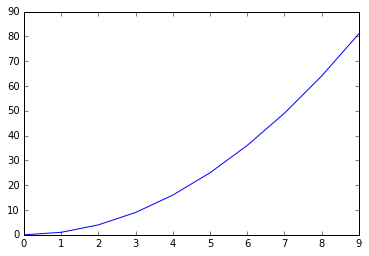

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt

p = plt.plot([i**2 for i in range(10)])
plt.savefig('destination_path.eps', format='eps', dpi=1200)

NameError: name 'itertools' is not defined

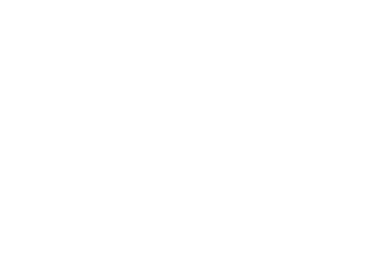

In [54]:
#### import itertools
import random
# http://stackoverflow.com/questions/10194482/custom-matplotlib-plot-chess-board-like-table-with-colored-cells

from matplotlib.table import Table

def main():
    grid_table(8, 8)
    plt.axis('scaled')
    plt.show()

def grid_table(nrows, ncols):
    fig, ax = plt.subplots()
    ax.set_axis_off()
    colors = ['white', 'lightgrey', 'dimgrey']
    tb = Table(ax, bbox=[0,0,2,2])
    for i,j in itertools.product(range(ncols), range(nrows)):
        tb.add_cell(i, j, 2./ncols, 2./nrows, text='{:0.2f}'.format(0.1234), 
                    loc='center', facecolor=random.choice(colors), edgecolor='grey') # facecolors=
    ax.add_table(tb)
    #ax.plot([0, .3], [.2, .2])
    #ax.add_line(plt.Line2D([0.3, 0.5], [0.7, 0.7], linewidth=2, color='blue'))
    return fig

main()

In [ ]:
class defaultkeydict(collections.defaultdict):
    """Like defaultdict, but the default_factory is a function of the key.
    >>> d = defaultkeydict(abs); d[-42]
    42
    """
    def __missing__(self, key):
        self[key] = self.default_factory(key)
        return self[key]